# Example of a one-dimensional constrained Gaussian Process

In [1]:
import torch
import gpytorch
from src.models.bounded_gp_model import BoundedGP
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Objective function
def objective_func(x):
    return torch.ones_like(x)

def constraint_func(x):
    return 2 * x + 4

In [3]:
noise = 0.05

# define train points
x_train = torch.Tensor([[-5], [-3], [4]])
y_train = objective_func(x_train) + torch.normal(mean=0, std=torch.ones_like(x_train[1])*noise,)

# define test points
x_test = torch.linspace(-8, 8, 100).reshape(-1, 1)

# define virtual observation locations
xv_points = torch.linspace(-1, 2, 10).reshape(-1, 1)

In [4]:
constrained_dims = [] # list of constrained dimensions
unconstrained_dims = [0] # list of constrained dimensions

model_unconstrained = BoundedGP(
    x_train,
    y_train,
    constrained_dims=constrained_dims,
    unconstrained_dims=unconstrained_dims,
    lengthscale_constraint=gpytorch.constraints.Interval(0, 4),
    lengthscale_hyperprior=gpytorch.priors.NormalPrior(0.8, 2),  # lengthscale = hyperprior.mean if not trained
    outputscale_constraint=gpytorch.constraints.Interval(0, 10),
    outputscale_hyperprior=gpytorch.priors.NormalPrior(4, 2),
    prior_mean=-5.)
model_unconstrained.likelihood.noise_covar.noise = noise ** 2

In [5]:
# unconstrained GP
prediction_unconstrained = model_unconstrained.posterior(X=x_test)
unconstrained_mean = prediction_unconstrained.mean.detach().numpy().reshape(-1)
unconstrained_std = torch.sqrt(prediction_unconstrained.variance.detach()).numpy().reshape(-1)


/Users/paulbrunzema/Documents/02_Code_Bases/constrained_gps/lib/python3.9/site-packages/gpytorch/lazy/lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


In [6]:
constrained_dims = [0] # list of constrained dimensions
unconstrained_dims = [] # list of unconstrained dimensions

model_constrained = BoundedGP(
    x_train,
    y_train,
    constrained_dims=constrained_dims,
    unconstrained_dims=unconstrained_dims,
    lengthscale_constraint=gpytorch.constraints.Interval(0, 4),
    lengthscale_hyperprior=gpytorch.priors.NormalPrior(0.8, 2),  # lengthscale = hyperprior.mean if not trained
    outputscale_constraint=gpytorch.constraints.Interval(0, 10),
    outputscale_hyperprior=gpytorch.priors.NormalPrior(4, 2),
    prior_mean=-5)
model_constrained.likelihood.noise_covar.noise = noise ** 2


In [7]:
print(torch.ones(xv_points.shape[0]) * np.infty)
print(constraint_func(xv_points))

xv_points_dict = {
    "xv": xv_points,
    "lb": constraint_func(xv_points).T[0],
    "ub": torch.ones(xv_points.shape[0]) * np.infty
}

posterior_options = {'evaluate_constrained': True,
                     'virtual_observation_points': xv_points_dict,
                     'nr_samples': 10000}

# constrained GP
prediction_constrained = model_constrained.posterior(X=x_test, observation_noise=False, **posterior_options)
constrained_mean = prediction_constrained.mean.detach().numpy().reshape(-1)
constrained_std = torch.sqrt(prediction_constrained.variance.detach()).numpy().reshape(-1)

tensor([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf])
tensor([[2.0000],
        [2.6667],
        [3.3333],
        [4.0000],
        [4.6667],
        [5.3333],
        [6.0000],
        [6.6667],
        [7.3333],
        [8.0000]])
Start minimax algorithm (Python implementation) for 10000 samples (D=10)...
Time taken for 10000 samples: 0.04s.


/Users/paulbrunzema/Documents/02_Code_Bases/constrained_gps/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/paulbrunzema/Documents/02_Code_Bases/constrained_gps/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/paulbrunzema/Documents/02_Code_Bases/constrained_gps/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


In [8]:
# get samples from unconstrained model
samples_unconstrained = model_unconstrained.get_samples_from_last_posterior(3)

# get samples from constrained model
samples_constrained = model_constrained.get_samples_from_last_posterior(3)

/Users/paulbrunzema/Documents/02_Code_Bases/constrained_gps/src/models/bounded_gp_model.py:414: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/TensorShape.cpp:2318.)
  sample = self.posterior_distribution.sample(sample_shape=torch.Size([n_samples])).detach().T


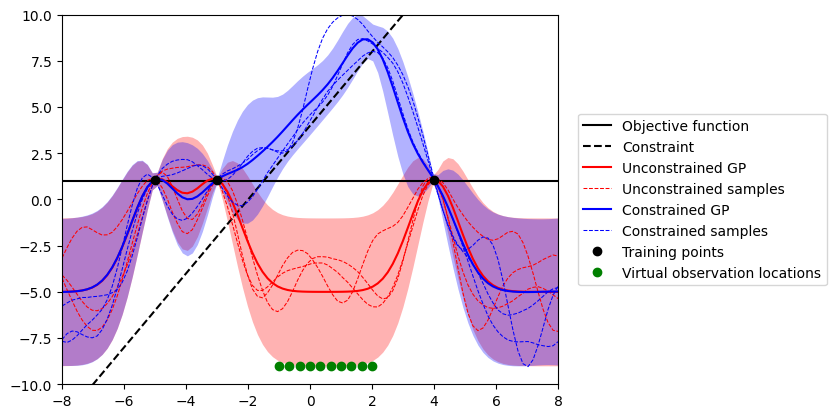

In [9]:
plt.plot(x_test.numpy(), objective_func(x_test).numpy(),'k-', label='Objective function')
plt.plot(x_test.numpy(), constraint_func(x_test).numpy(),'k--', label='Constraint')

# unconstrained posterior
plt.plot(x_test.numpy().reshape(-1), unconstrained_mean,'r-',label='Unconstrained GP')
plt.fill_between(x_test.numpy().reshape(-1), unconstrained_mean - 2 * unconstrained_std,
                 unconstrained_mean + 2 * unconstrained_std,
                 alpha=0.3, color='r', lw=0)
plt.plot(x_test.numpy().reshape(-1), samples_unconstrained,'r--',linewidth=0.75,
         label=['Unconstrained samples',None,None])

# constrained posterior
plt.plot(x_test.numpy().reshape(-1), constrained_mean,'b-', label='Constrained GP')
plt.fill_between(x_test.numpy().reshape(-1), constrained_mean - 2 * constrained_std,
                 constrained_mean + 2 * constrained_std,
                 alpha=0.3, color='b', lw=0)
plt.plot(x_test.numpy().reshape(-1), samples_constrained,'b--',linewidth=0.75,
         label=['Constrained samples',None,None])

plt.plot(x_train.numpy(), y_train.numpy(),'ko', label='Training points')
plt.plot(xv_points, torch.ones(xv_points.shape[0]) * -9, 'go', label='Virtual observation locations')
plt.xlim([x_test[0], x_test[-1]])
plt.ylim([-10, 10])
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()
plt.close()